In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import zscore

## Load and prepare data

In [2]:
# load data
spei_df = pd.read_csv('Data/district_province_spei_growingperiod.csv')

# rename season_year column for compatability with forest loss
spei_df = spei_df.rename(columns={'season_year': 'year', 'mean_growing_spei': 'mean_spei', 'median_growing_spei': 'median_spei'})

# load forest loss data
forest_df = pd.read_csv('Data/district_forest_cover.csv')
forest_df['year'] = forest_df['year'].astype(int)

# merge SPEI and forest data
merged_df = pd.merge(spei_df, forest_df, on=['district', 'year'])

Lag 1: 1380 rows


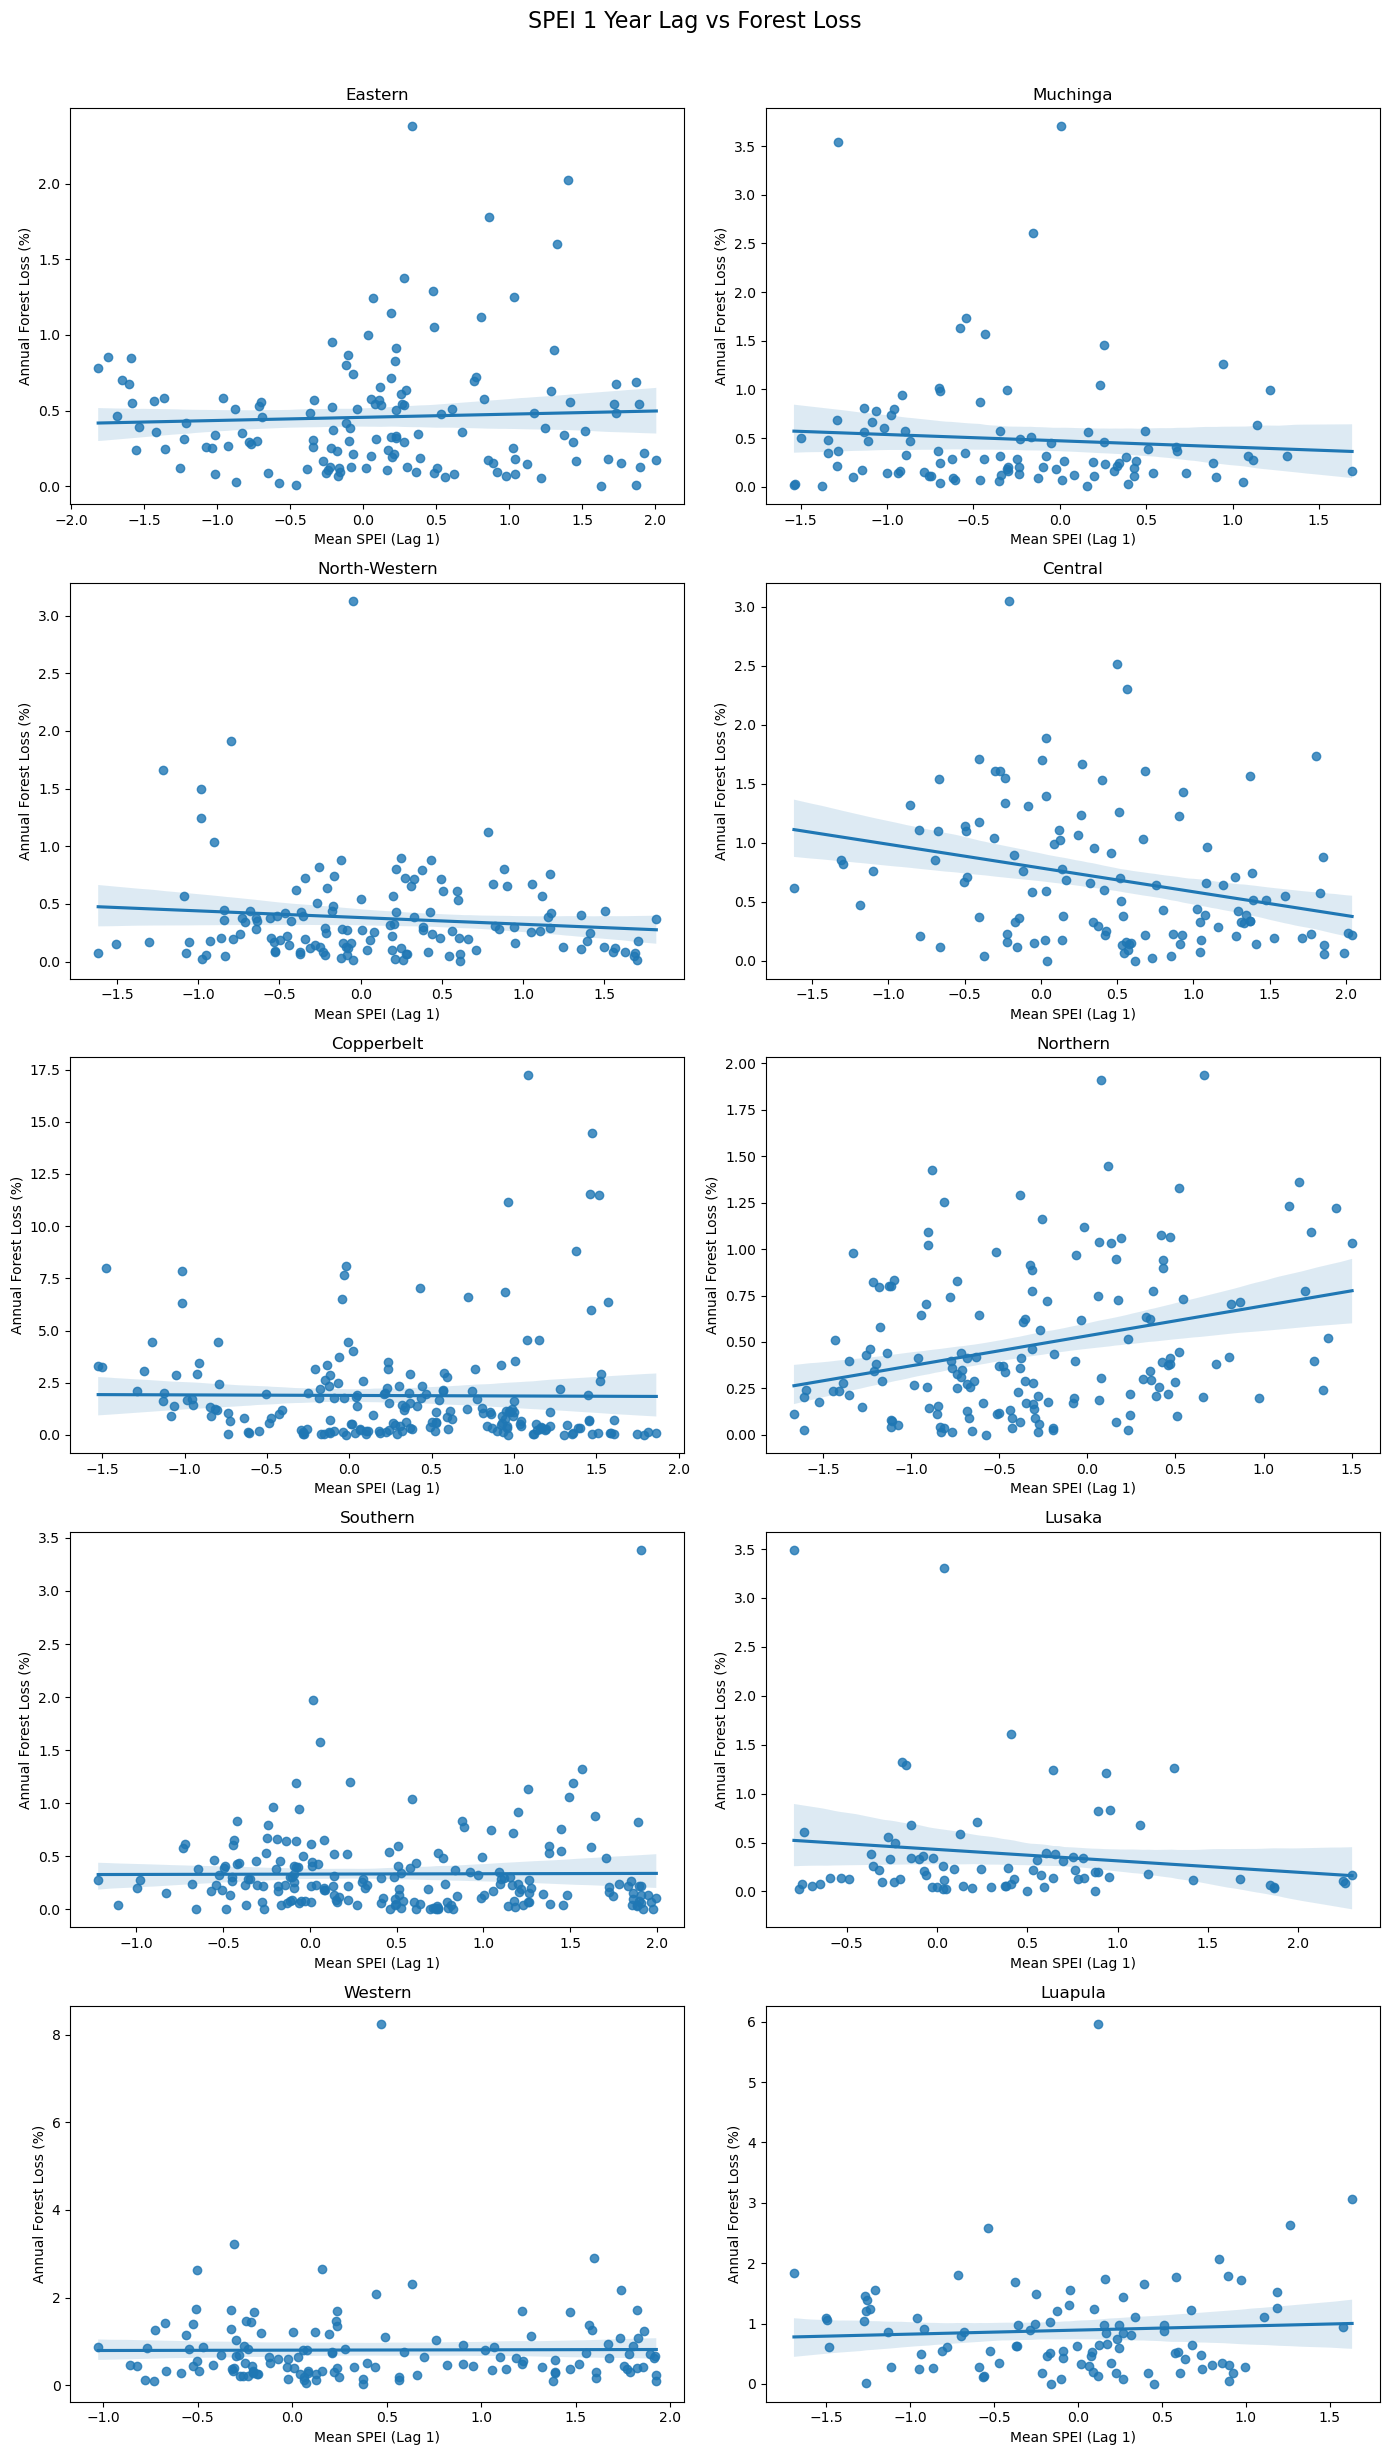

Lag 2: 1311 rows


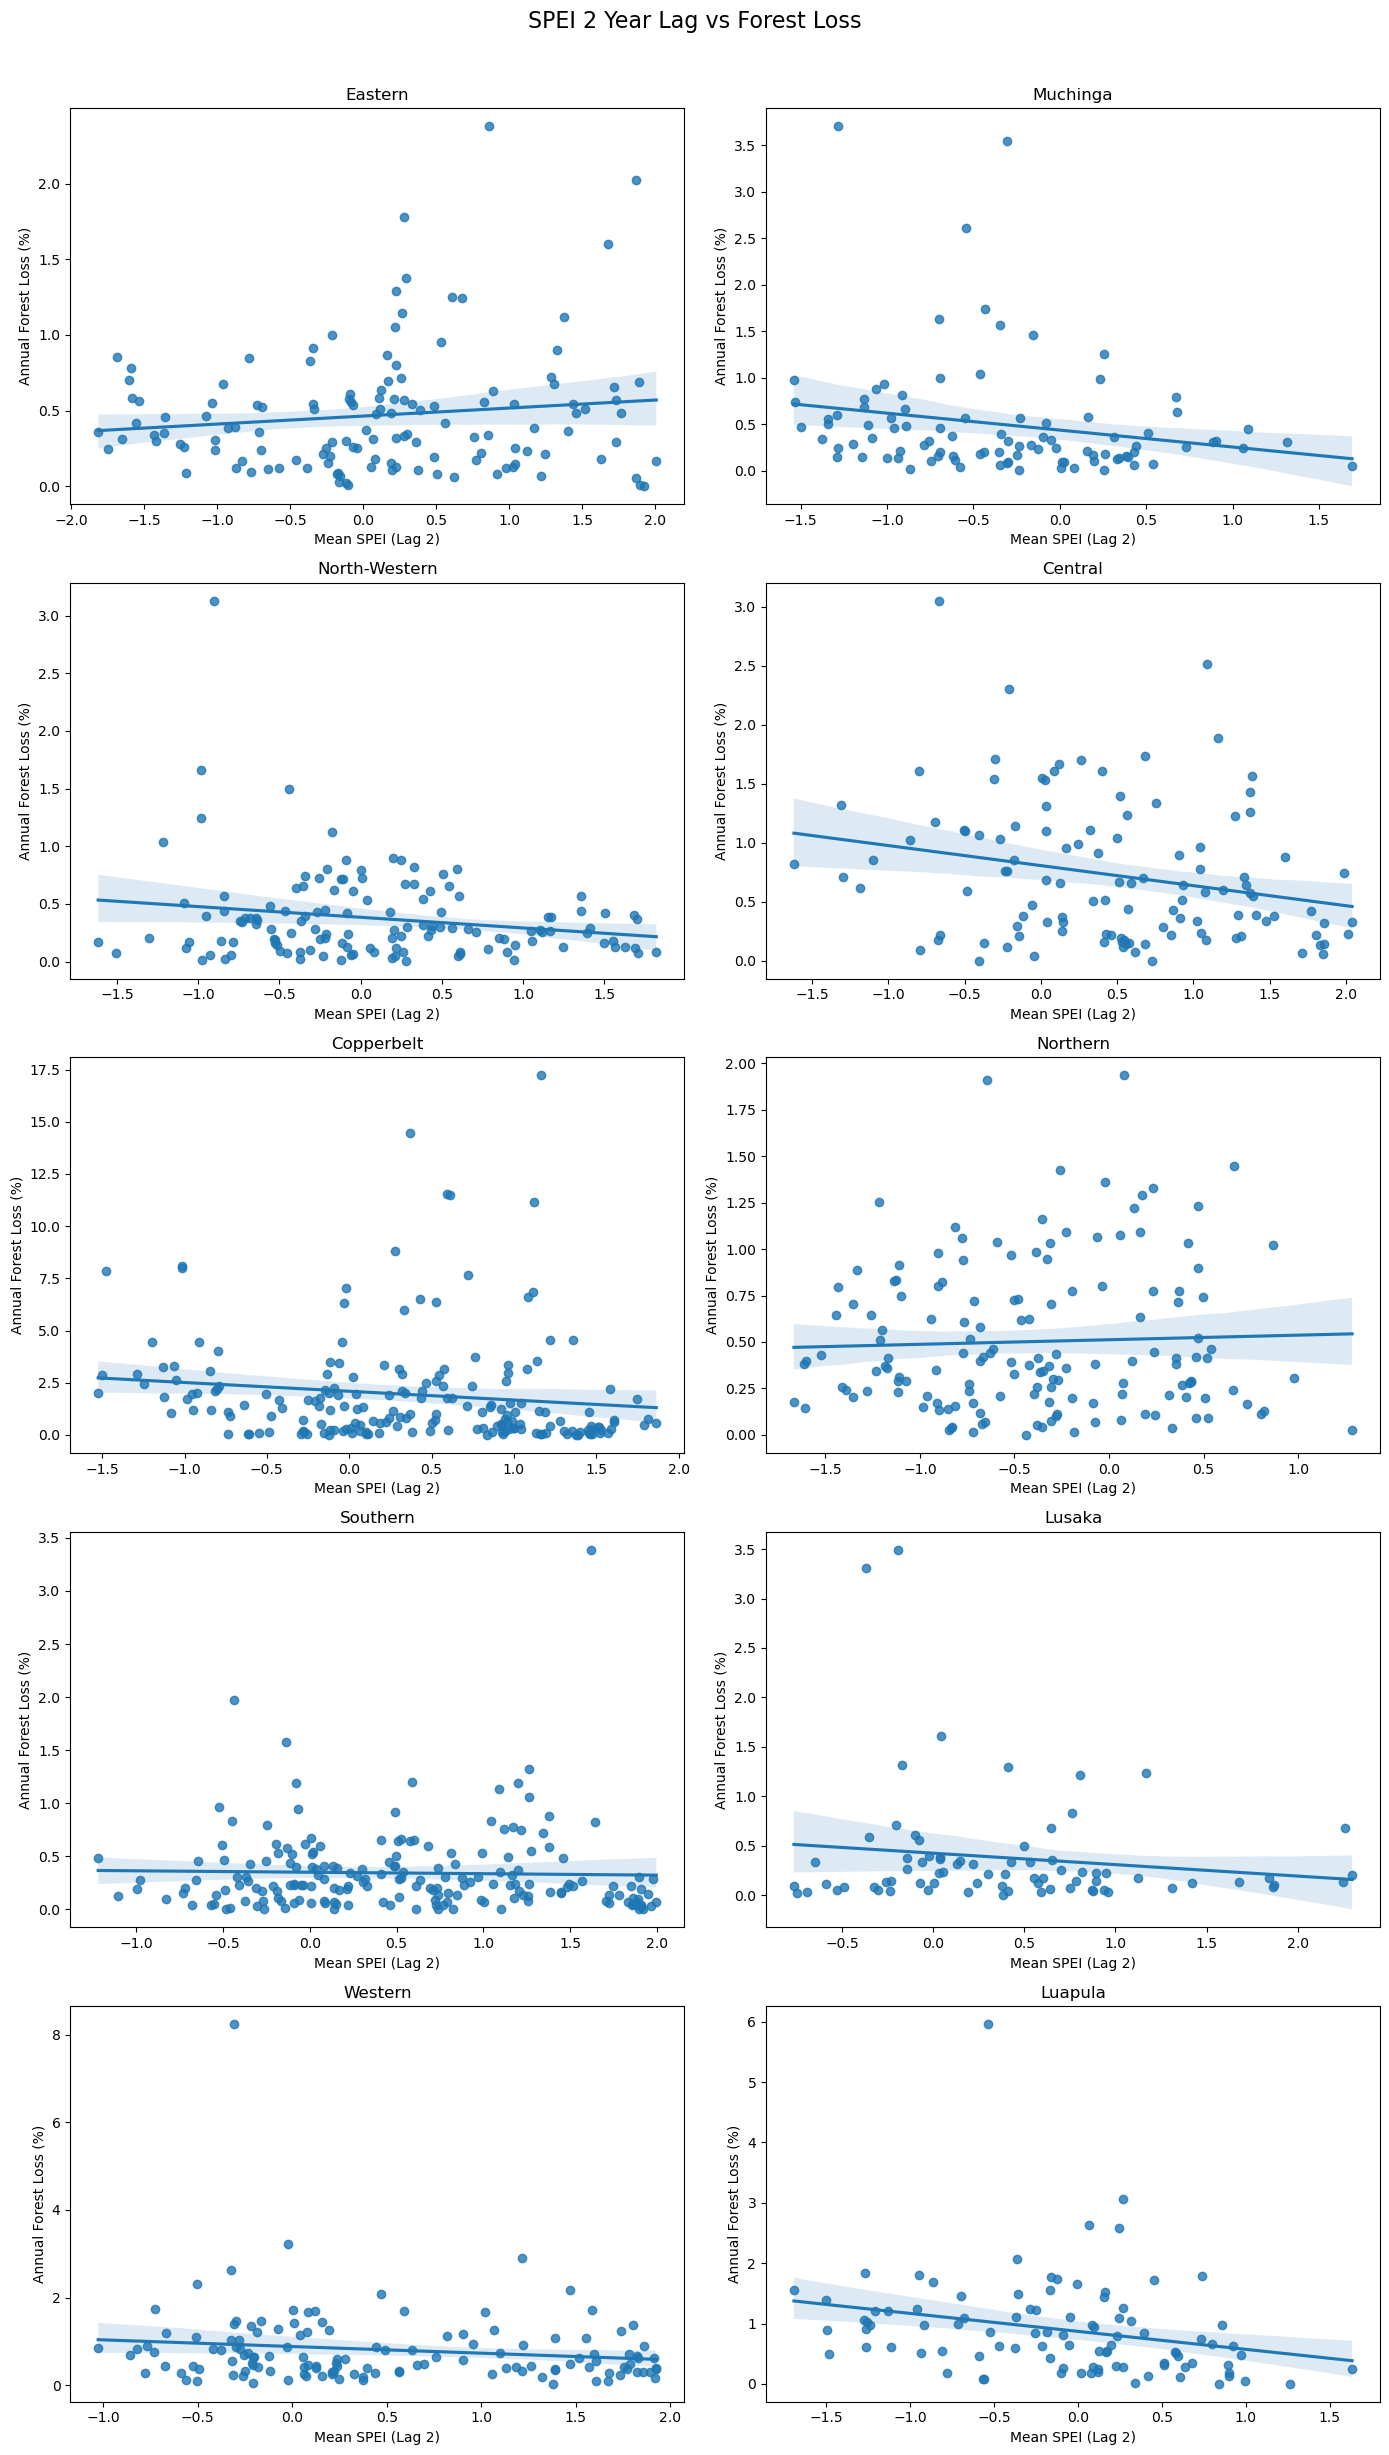

Lag 3: 1242 rows


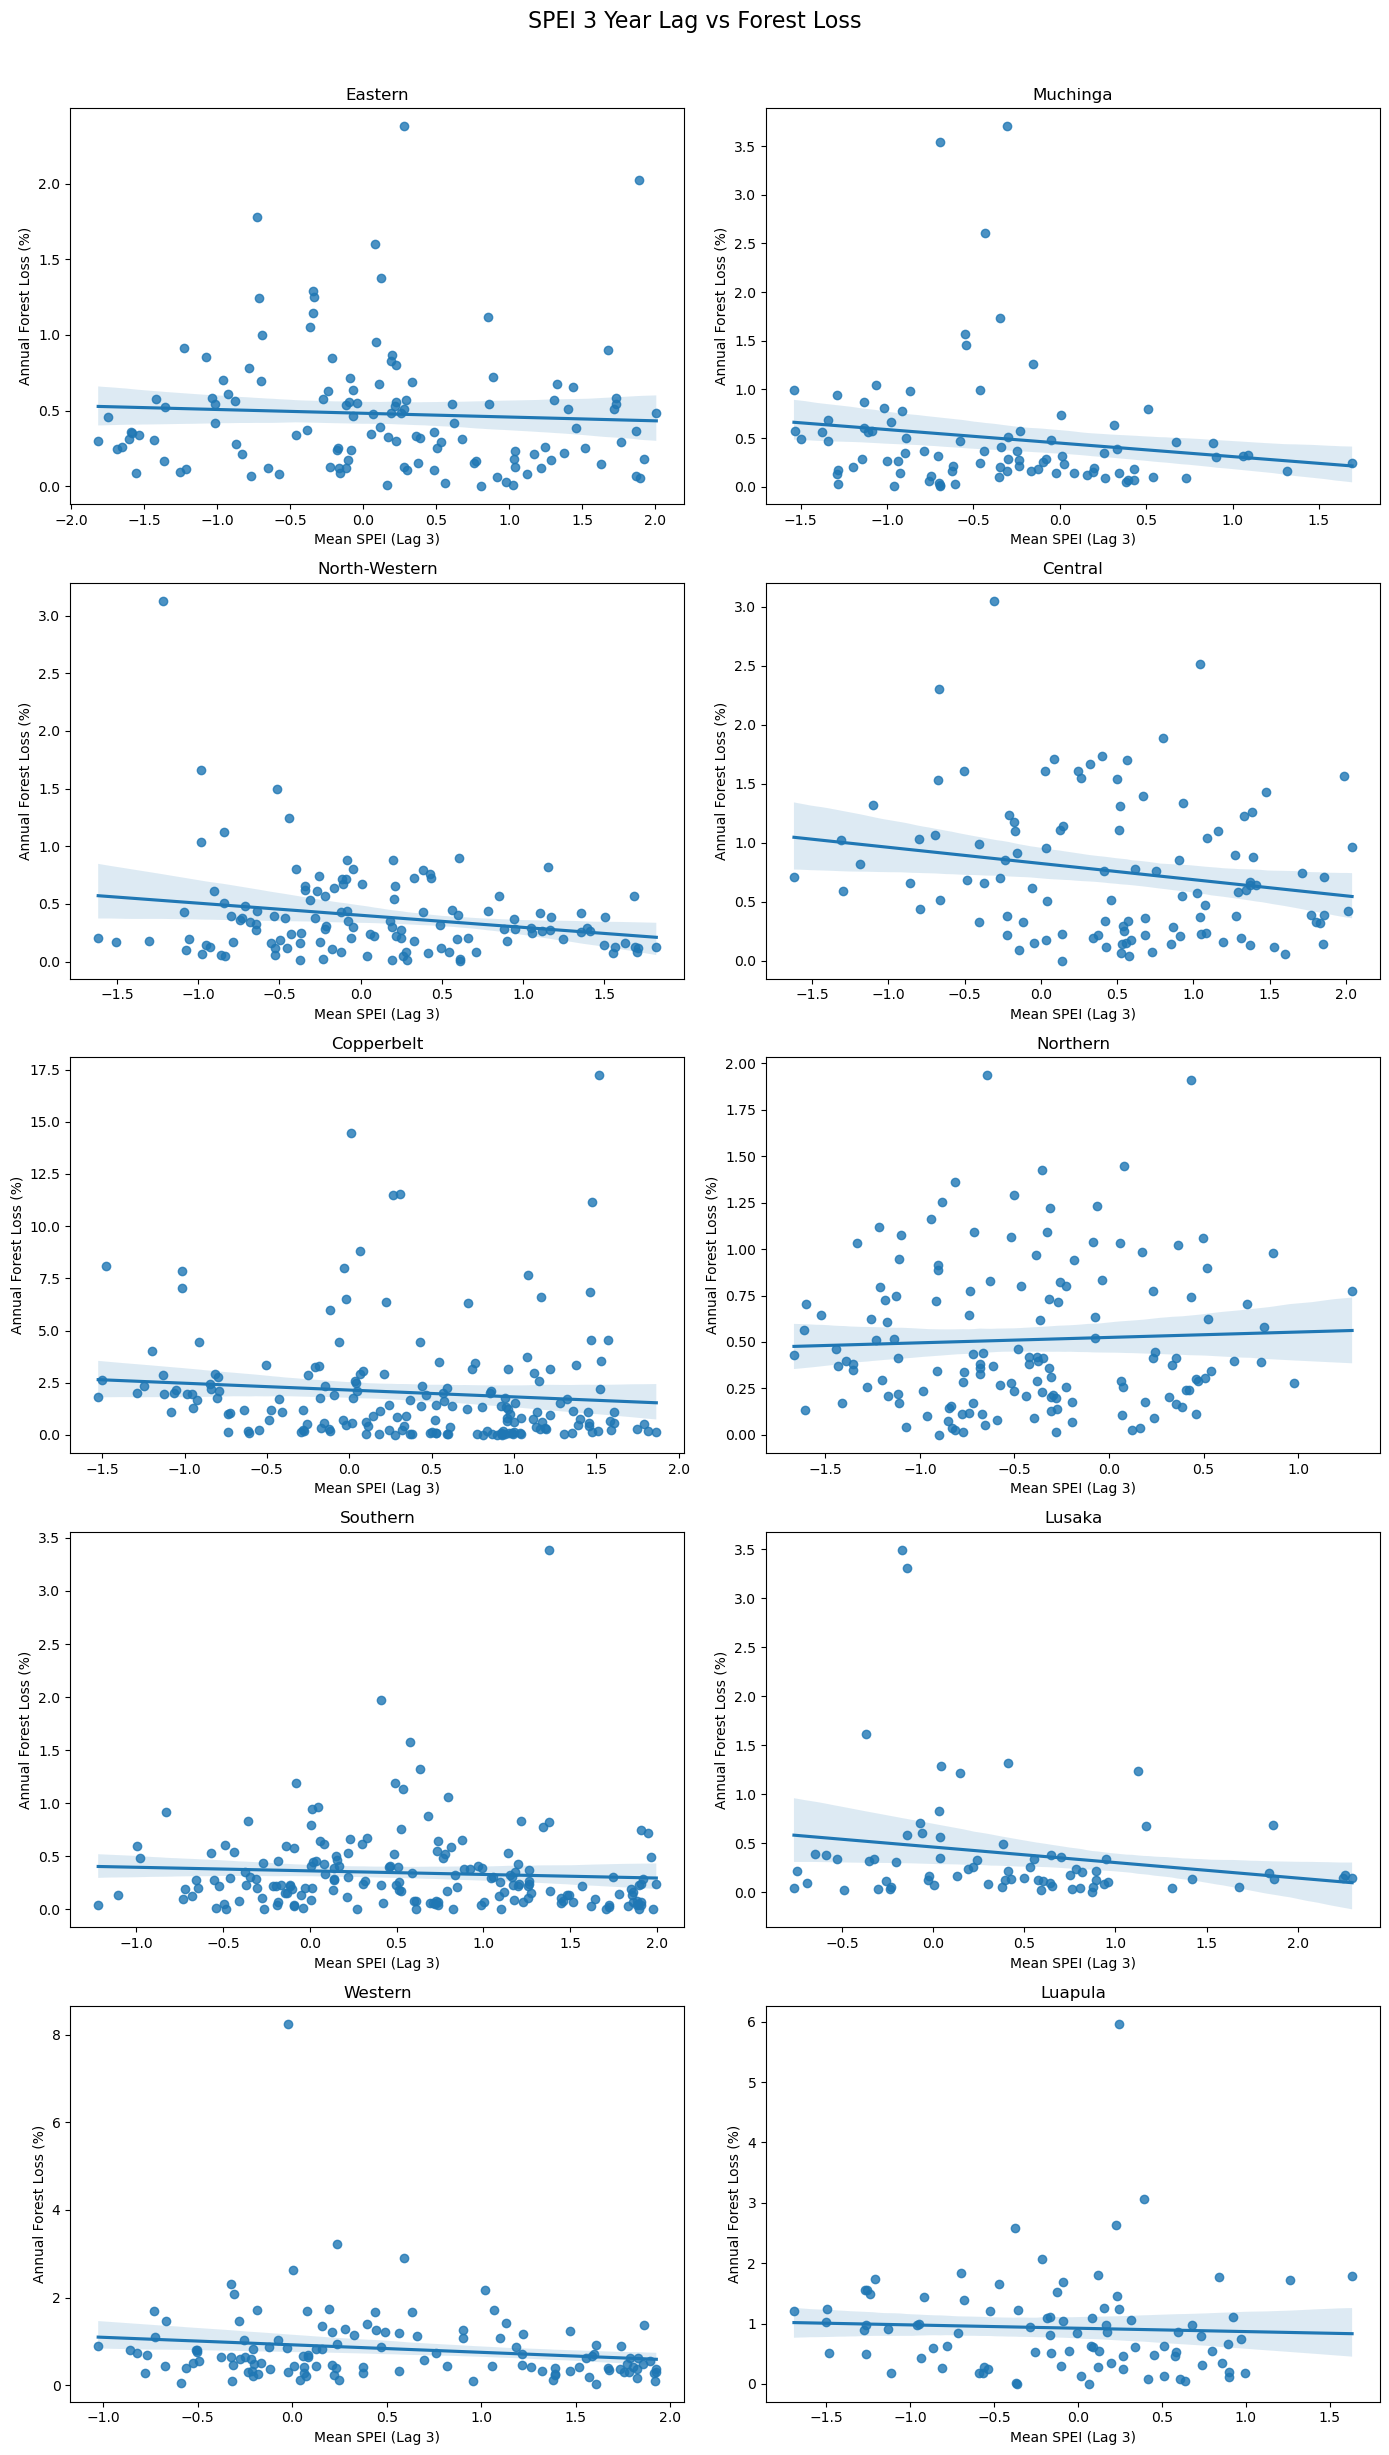

Lag 4: 1173 rows


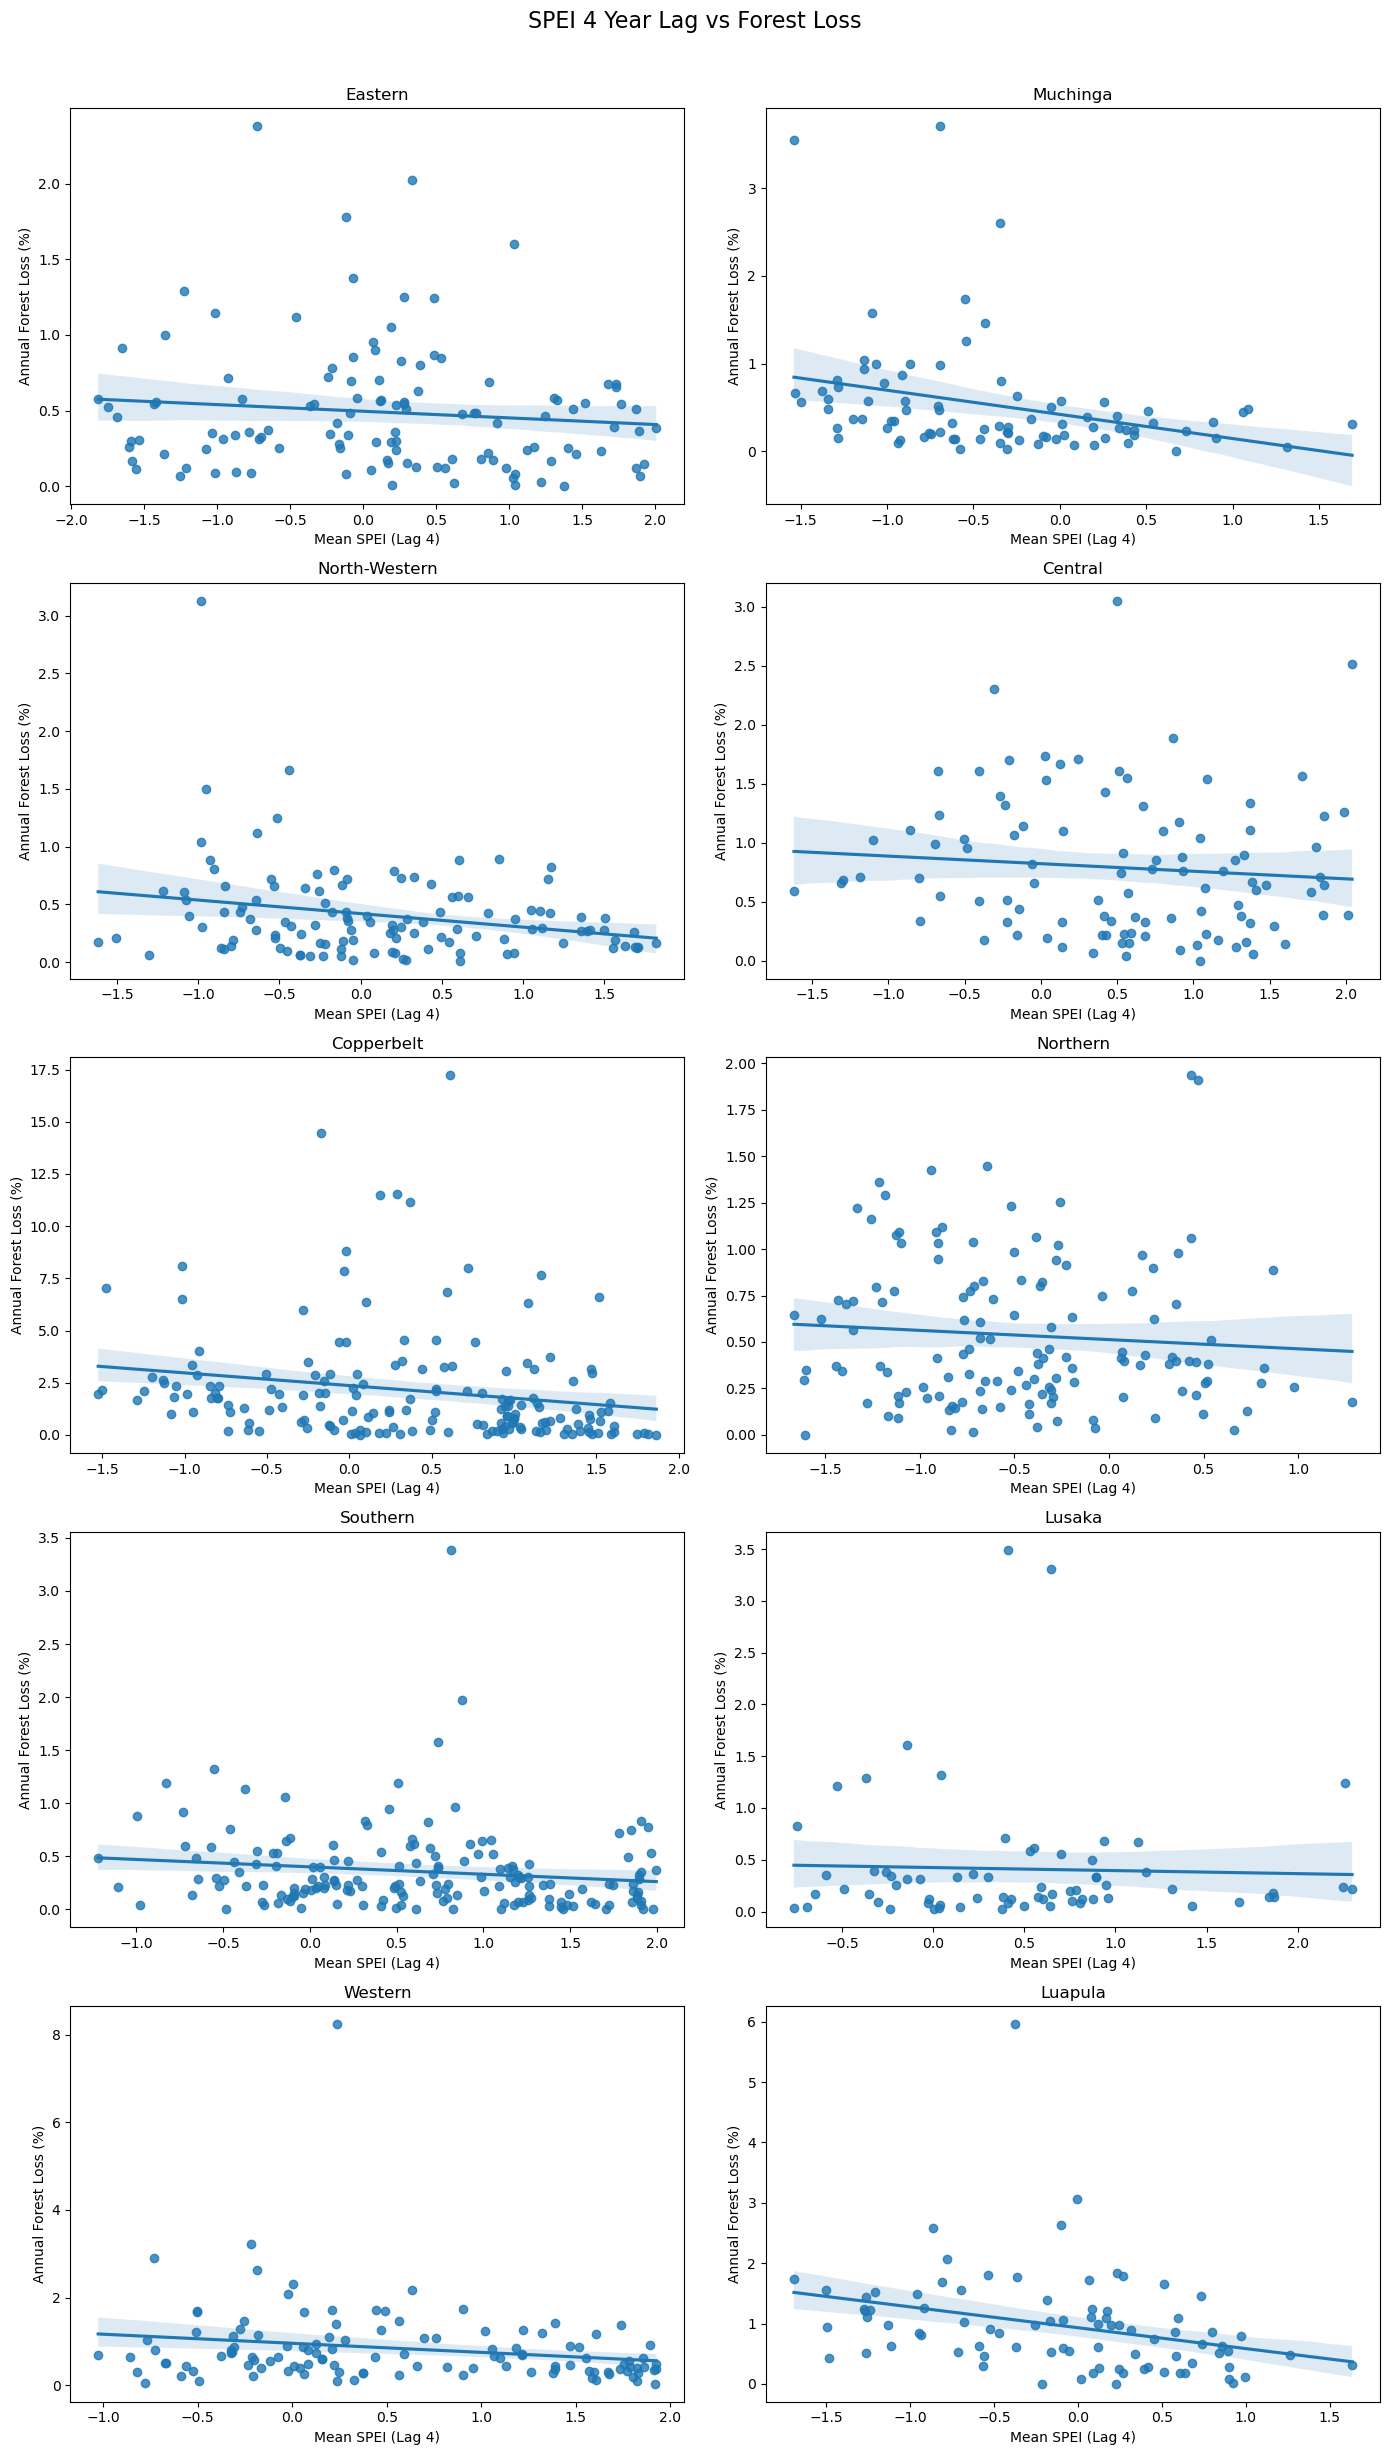

Lag 5: 1104 rows


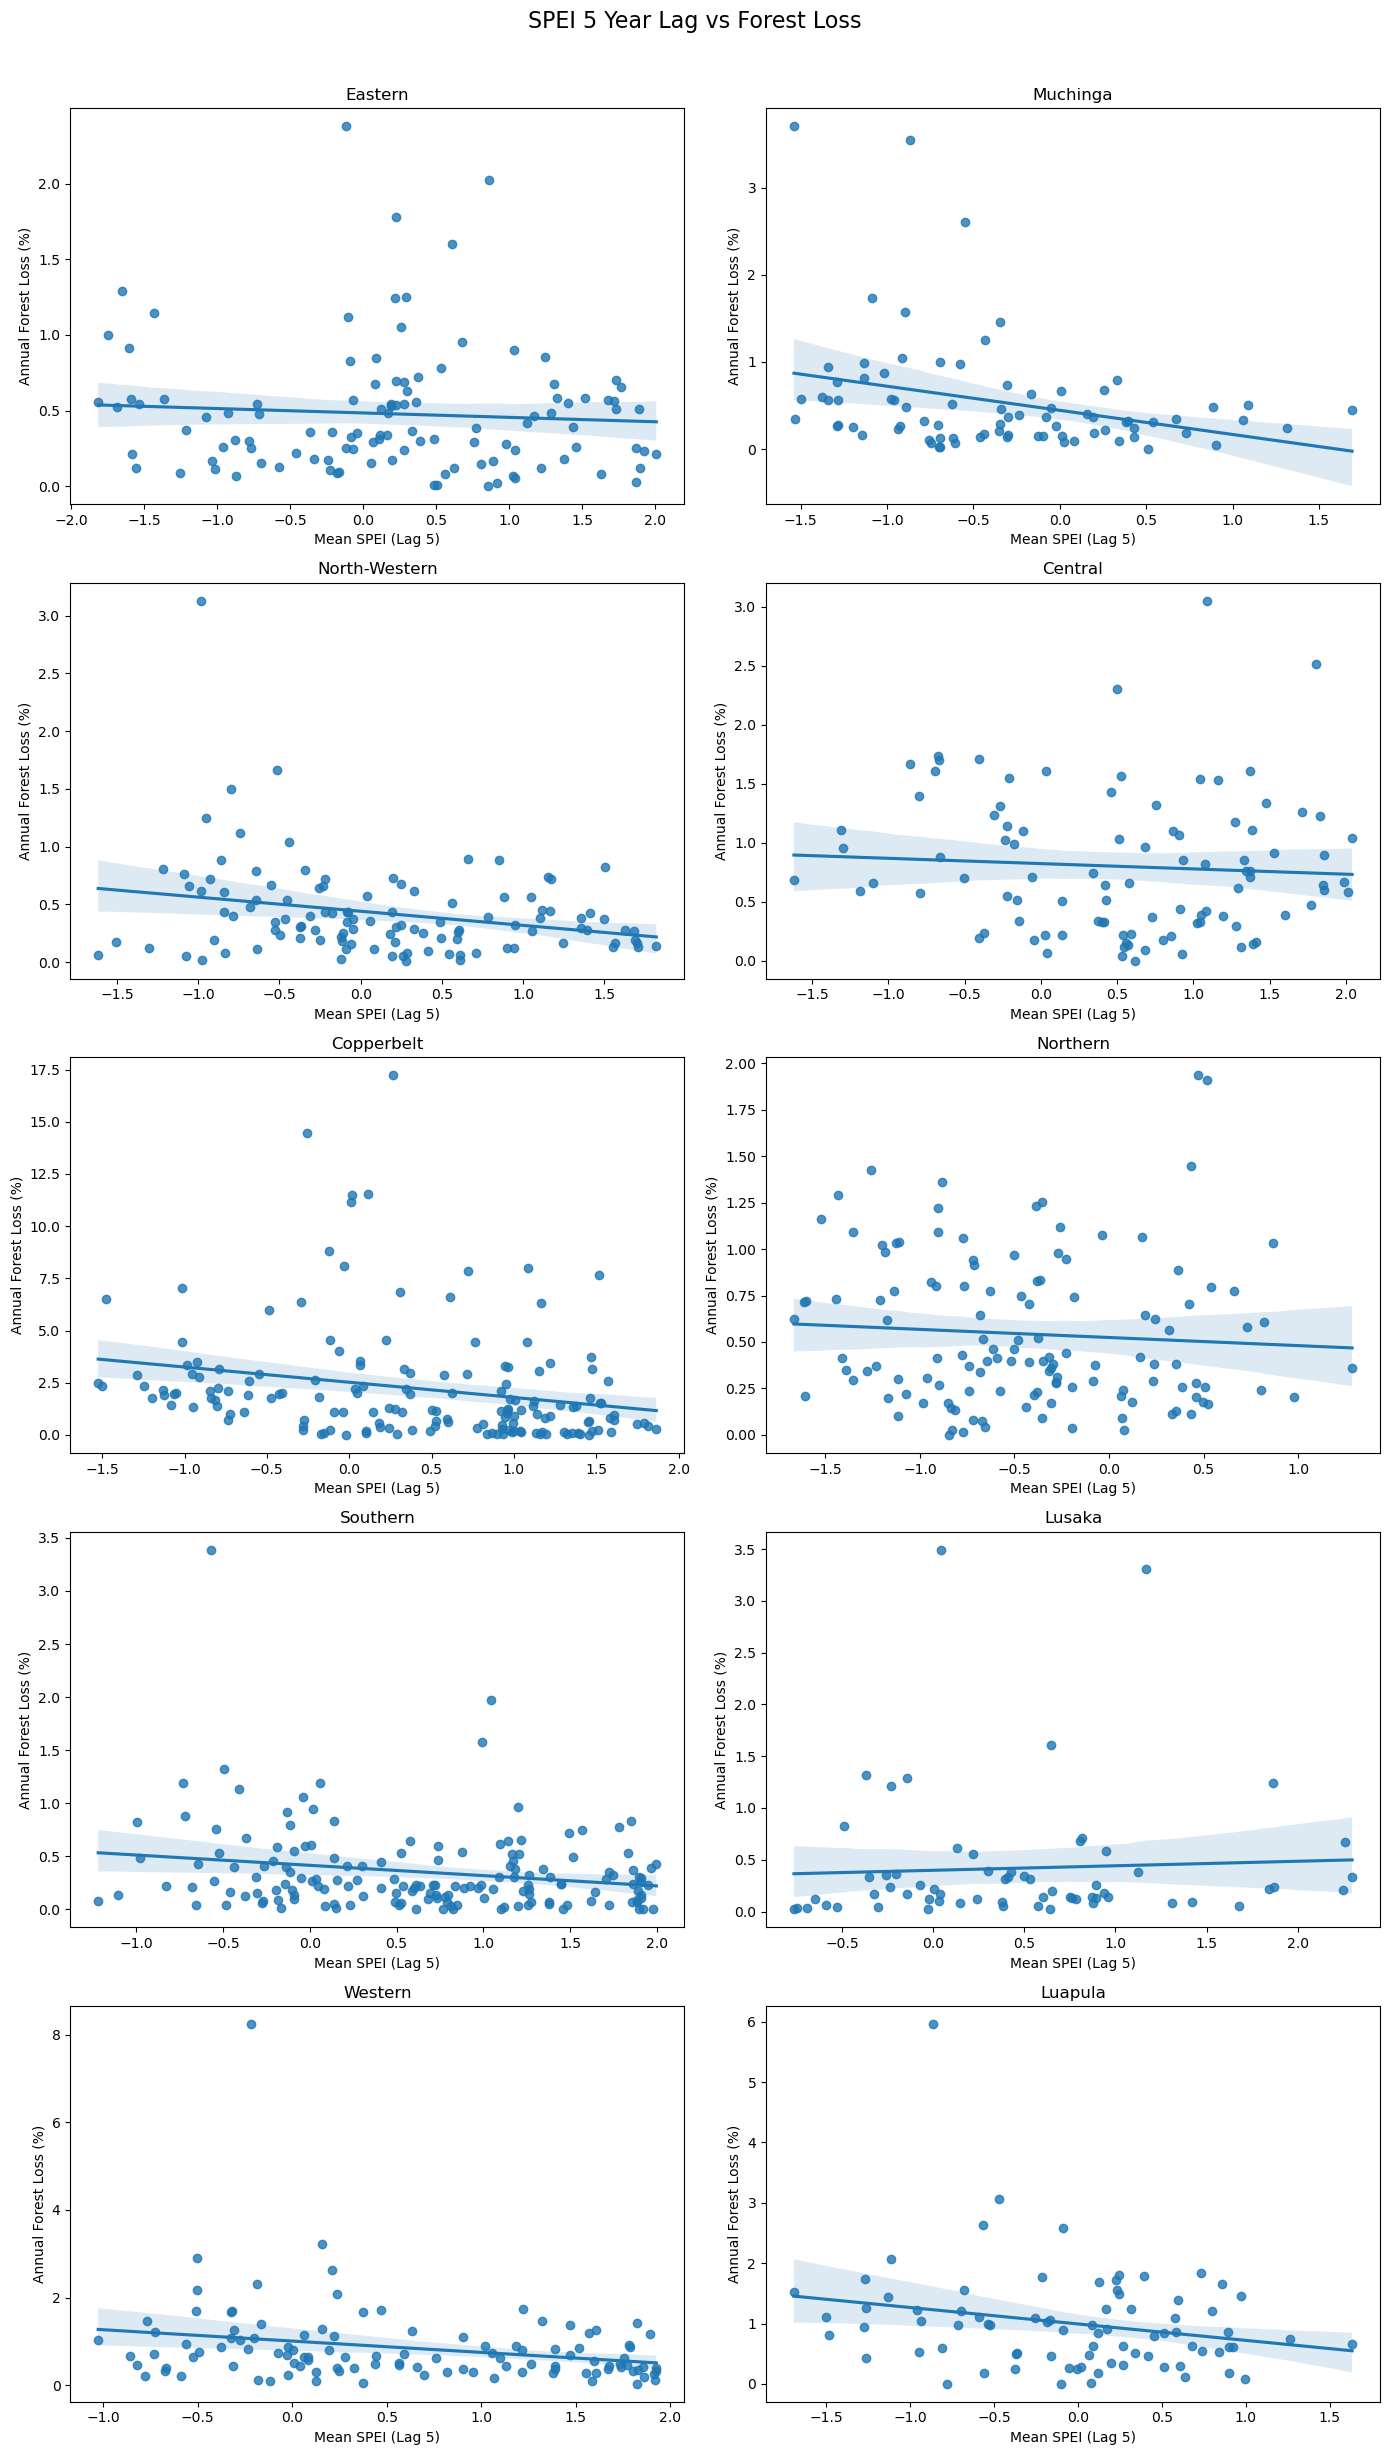

In [3]:
# generate lags
for lag in range(1, 6):
    merged_df[f'mean_spei_lag{lag}'] = merged_df.groupby('district')['mean_spei'].shift(lag)

plot_df = merged_df.copy()

# get unique provinces
provinces = plot_df['province'].unique()

# loop through each lag
for lag in range(1, 6):
    lag_col = f'mean_spei_lag{lag}'
    if lag_col not in plot_df.columns:
        print(f'Column {lag_col} not found. Skipping.')
        continue
    # drop rows with NA values for each lag
    lag_df = plot_df.dropna(subset=[lag_col]) 
    print(f'Lag {lag}: {len(lag_df)} rows')

    # set up plot grid
    cols = 2
    rows = (len(provinces) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
    axes = axes.flatten()

    # plot per province
    for i, province in enumerate(provinces):
        ax = axes[i]
        province_data = lag_df[lag_df['province'] == province]

        sns.regplot(
            data=province_data,
            x=lag_col,
            y='percent_loss_annual',
            ax=ax
        )

        ax.set_title(province)
        ax.set_xlabel(f'Mean SPEI (Lag {lag})')
        ax.set_ylabel('Annual Forest Loss (%)')
    

    # remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'SPEI {lag} Year Lag vs Forest Loss', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [4]:
def compute_lag_corrs(group):
    results = {}
    for lag in range(1, 6):
        col = f'mean_spei_lag{lag}'
        y_col = 'percent_loss_annual'
        if col in group:
            # drop NaNs
            valid = group[[col, y_col]].dropna()
            if len(valid) >= 3:
                slope, intercept, r_value, p_value, std_err = linregress(valid[col], valid[y_col])
                results[f'corr_lag{lag}'] = r_value
                results[f'pval_lag{lag}'] = p_value
                results[f'slope_lag{lag}'] = slope
                results[f'r2_lag{lag}'] = r_value ** 2
            else:
                results[f'corr_lag{lag}'] = None
                results[f'pval_lag{lag}'] = None
                results[f'slope_lag{lag}'] = None
                results[f'r2_lag{lag}'] = None

        else:
            results[f'corr_lag{lag}'] = None
            results[f'pval_lag{lag}'] = None
            results[f'slope_lag{lag}'] = None
            results[f'r2_lag{lag}'] = None
            
    return pd.Series(results)

plot_df['mean_spei_lag1'] = plot_df.groupby('district')['mean_spei'].shift(1)
plot_df['mean_spei_lag2'] = plot_df.groupby('district')['mean_spei'].shift(2)
plot_df['mean_spei_lag3'] = plot_df.groupby('district')['mean_spei'].shift(3)
plot_df['mean_spei_lag4'] = plot_df.groupby('district')['mean_spei'].shift(4)
plot_df['mean_spei_lag5'] = plot_df.groupby('district')['mean_spei'].shift(5)

multi_lag_corrs = (
    plot_df.groupby('district')[['mean_spei_lag1', 'mean_spei_lag2', 'mean_spei_lag3', 'mean_spei_lag4', 'mean_spei_lag5', 'percent_loss_annual']]
    .apply(compute_lag_corrs)
    .reset_index()
)

# Filter and print significant correlations for each lag
for lag in range(1, 6):
    corr_col = f'corr_lag{lag}'
    pval_col = f'pval_lag{lag}'
    slope_col = f'slope_lag{lag}'
    r2_col = f'r2_lag{lag}'
    
    significant = multi_lag_corrs[multi_lag_corrs[pval_col] < 0.05][['district', corr_col, pval_col, slope_col, r2_col]]
    
    print(f'\nSignificant correlations for Lag {lag} (p < 0.05):')
    print(significant.sort_values(by=corr_col, ascending=False).to_string(index=False))


Significant correlations for Lag 1 (p < 0.05):
district  corr_lag1  pval_lag1  slope_lag1  r2_lag1
Mpulungu   0.626487   0.003121    0.134870 0.392486
   Mbala   0.592410   0.005918    0.304071 0.350949
   Isoka   0.494574   0.026636    0.115370 0.244603
  Mumbwa  -0.477934   0.033060   -0.296497 0.228421

Significant correlations for Lag 2 (p < 0.05):
district  corr_lag2  pval_lag2  slope_lag2  r2_lag2
Mpulungu   0.570805   0.010699    0.148288 0.325818
 Chavuma  -0.476628   0.039094   -0.486949 0.227175
  Mwense  -0.477635   0.038624   -0.401469 0.228135
   Mansa  -0.519870   0.022519   -0.492783 0.270265

Significant correlations for Lag 3 (p < 0.05):
district  corr_lag3  pval_lag3  slope_lag3  r2_lag3
 Serenje  -0.499451   0.034831   -0.131849 0.249451
Chingola  -0.521609   0.026411   -0.484231 0.272076
 Chavuma  -0.535638   0.021963   -0.534558 0.286908

Significant correlations for Lag 4 (p < 0.05):
     district  corr_lag4  pval_lag4  slope_lag4  r2_lag4
        Mansa  -0.49741

In [7]:
for lag in range(1, 6):
    col = f'mean_spei_lag{lag}'
    z_col = f'z_spei_lag{lag}'
    plot_df[z_col] = (
        plot_df.groupby('district')[col]
        .transform(lambda x: (x - x.mean()) / x.std())
    )

plot_df.tail()

,district,year,mean_spei,median_spei,n_months,province,province_avg_start_date,province_avg_end_date,forest_cover_ha,loss_m2,...,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5,z_spei_lag1,z_spei_lag2,z_spei_lag3,z_spei_lag4,z_spei_lag5
1444,Zambezi,2017,-0.165492,-0.212525,5,North-Western,November 04,May 06,598630.212278,4.351229e+07,...,-0.343640,-0.257505,0.325636,1.152756,1.168887,-0.588172,-0.448321,0.303967,1.323972,1.285482
1445,Zambezi,2018,-0.397999,-0.367019,6,North-Western,November 04,May 06,594211.255070,4.418957e+07,...,-0.165492,-0.343640,-0.257505,0.325636,1.152756,-0.343318,-0.563658,-0.458084,0.261649,1.265330
1446,Zambezi,2019,-0.205716,-0.310716,6,North-Western,November 04,May 06,590540.125435,3.671130e+07,...,-0.397999,-0.165492,-0.343640,-0.257505,0.325636,-0.662885,-0.325115,-0.570647,-0.487315,0.232055
1447,Zambezi,2020,0.217030,0.208446,6,North-Western,November 04,May 06,586751.028881,3.789097e+07,...,-0.205716,-0.397999,-0.165492,-0.343640,-0.257505,-0.398603,-0.636446,-0.337842,-0.597945,-0.496431
1448,Zambezi,2021,-0.391047,-0.489134,6,North-Western,November 04,May 06,582053.919994,4.697109e+07,...,0.217030,-0.205716,-0.397999,-0.165492,-0.343640,0.182436,-0.378975,-0.641683,-0.369138,-0.604035
